In [1]:
%load_ext autoreload
%autoreload 2
import sys

# insert at 1, 0 is the script path (or ‘’ in REPL)
sys.path.insert(1, '../')


import numpy as np
import torch
from torch.utils.data import DataLoader
from bayesian_neural_net import CLSTM_cell
from bayesian_neural_net import ConvCell
from bayesian_neural_net import ConvRelu
from bayesian_neural_net import DeconvRelu
from bayesian_neural_net import Encoder_pro
from bayesian_neural_net import Decoder_pro
from bayesian_neural_net import ED_pro

from simulation_dataset import MovingMNIST
from simulation_dataset_datamodule import DatasetDataModule
from trainer import LightningED
from visualization import plot_spatio_temporal_data

import pytorch_lightning as pl

# set the seed globally for reproducibility
torch.manual_seed(0)
np.random.seed(0)

GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!


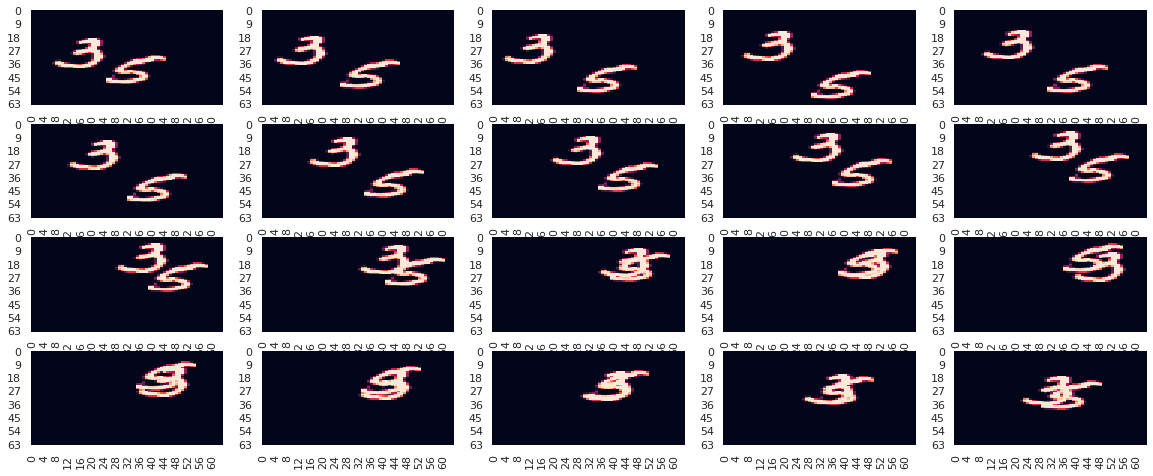

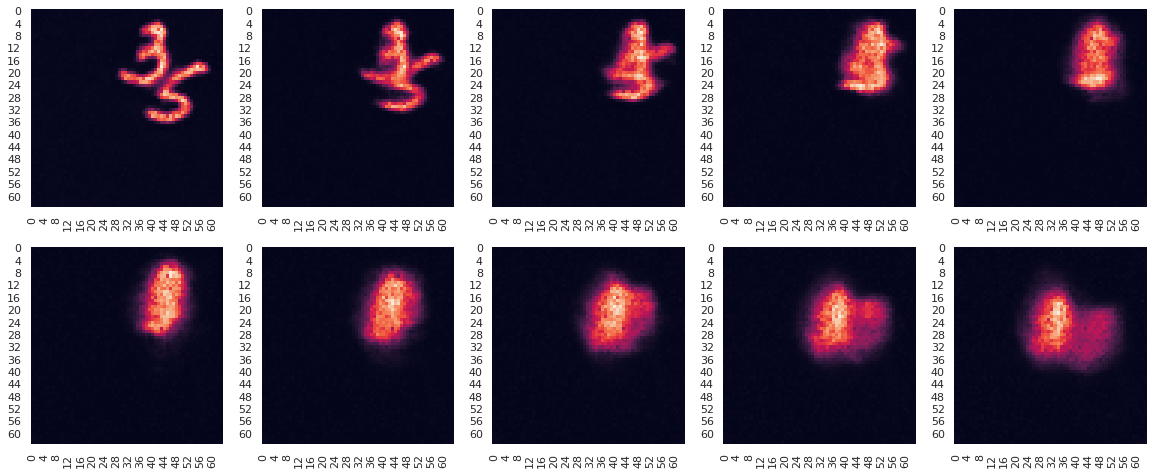

error for the new sample is 0.0192


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
root = '../../data'
n_frames_input = 10
n_frames_output = 10
num_digits = 2
image_size = 64
digit_size = 28
N = 1  # total number of samples including training and validation data

test_data = MovingMNIST(root, n_frames_input, n_frames_output, num_digits, image_size, digit_size, N, use_fixed_dataset=False)

test_data_loader = DataLoader(test_data, 1)

# build the model
# build the model
# encoder pro
rnns = [CLSTM_cell(shape=(64, 64), input_channels=16, filter_size=5, num_features=64,
                   dropout_rate=0.1),
        CLSTM_cell(shape=(32, 32), input_channels=64, filter_size=5, num_features=96, dropout_rate=0.1),
        CLSTM_cell(shape=(16,16), input_channels=96, filter_size=5, num_features=96, dropout_rate=0.1) ]

convrelus = [ConvRelu(1, 16, 3, 1, 1, dropout_rate=0.1),
             ConvRelu(64, 64, 3, 2, 1, dropout_rate=0.1),
             ConvRelu(96, 96, 3, 2, 1, dropout_rate=0.1)]

encoder_net = Encoder_pro(rnns, convrelus)

# input for encoder
S = 10
B = 2
input_channels = 1
H = 64
W = 64
input_for_encoder = [torch.randn(B, S, input_channels, H, W)]

# decoder_pro
rnns = [CLSTM_cell(shape=(16, 16), input_channels=96, filter_size=5, num_features=96, dropout_rate=0.1),
        CLSTM_cell(shape=(32, 32), input_channels=96, filter_size=5, num_features=96, dropout_rate=0.1),
        CLSTM_cell(shape=(64, 64), input_channels=96, filter_size=5, num_features=64, dropout_rate=0.1)]

deconvrelus = [DeconvRelu(96, 96, 4, 2, 1, dropout_rate=0.1),
               DeconvRelu(96, 96, 4, 2, 1, dropout_rate=0.1),
               DeconvRelu(64, 16, 3, 1, 1, dropout_rate=0.1)]

cnn = ConvCell(in_channels=16, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder_pro(rnns, deconvrelus, cnn)

# ED net
ED_net = ED_pro(encoder_net, decoder_net)

mc_dropout = 20
learning_rate = 1e-4
max_epoch = 1
model = LightningED(ED_net, mc_dropout, learning_rate)



# load from checkpoint
model.load_from_checkpoint(checkpoint_path='moving_mnist_pro2.cpkt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)

model.to(device)  # transfer the model to gpu

# predict for one sample
for idx, batch in enumerate(test_data_loader):

    idx, input_for_encoder, input_for_decoder, additional_time_invariant_input, true_output, seq_len = batch
    
    true_data = torch.cat((input_for_encoder[0], true_output[0]), 1)
    true_data = true_data.squeeze()



    input_for_encoder = [i.to(device) for i in input_for_encoder]
    if len(input_for_decoder) != 0:
        input_for_decoder = [i.to(device) for i in input_for_decoder]
    if len(additional_time_invariant_input) != 0:
        additional_time_invariant_input = [i.to(device) for i in additional_time_invariant_input]


    output = model(input_for_encoder, input_for_decoder, additional_time_invariant_input, seq_len)
    
    if idx == 0:
        break
        

# transfer the tensor on gpu on cpu
predicted_data = torch.cat(output, dim=1).cpu().detach().numpy().squeeze(0).squeeze(1)
true_data = true_data.cpu().detach().numpy()

# plot the true data
plot_spatio_temporal_data(true_data)
plot_spatio_temporal_data(predicted_data)


print("error for the new sample is %.4f"%np.mean((predicted_data - true_data[10:, ...])**2))